## Data cleaning

The provided file `../data/ab_ag.tsv` contains multiple lines for each pdb_id, sometimes Hchain or Lchain are missing, etc.

This needs to be cleaned before one can process the data further.

Here we perform the following cleaning step:

- remove lines where any of
    - method
    - model
    - Hchain 
    - Lchain 
    - antigen_chain 
    - antigen_type
    - antigen_species

    are missing

- restrict to structures where antigen_type = 'protein', i.e. the antibody binds to a single protein antigen chain

- remove structures where structure is single chain Fv (i.e. require scfv = False)

- restrict to structures with resolution <= 3.25 A

- for pdb_ids with multiple rows, only keep the first row

  Many pdb_ids have several rows in the ab_ag data frame. These correspond to different Ab-Ag complexes that have been co-crystallized. Inclusion of multiple complexes might skew the results. 



In [1]:
import pandas as pd
import os.path

# path to dataframe
df = pd.read_csv("../data/ab_ag.tsv", sep="\t")

df_filtered= (df
                .assign(resolution = pd.to_numeric(df["resolution"], errors='coerce'))
                .get(["pdb", "Hchain", "Lchain", "model", "antigen_chain",
                        "antigen_type", "antigen_name", "compound", "organism",
                        "heavy_species", "light_species", "antigen_species",
                        "resolution", "method", "scfv", "engineered", 
                        "heavy_subclass", "light_subclass", "light_ctype"])
                .dropna(subset=["pdb", "Hchain", "Lchain", 
                                "model", "antigen_chain", "antigen_type",
                                "antigen_species", "method"])
                .query("scfv== False and resolution <= 3.25 and antigen_type == 'protein'")
                .groupby("pdb")
                .head(1))

df_filtered.shape
                

(1489, 19)

We further restrict our analysis to structures involving one of the three antigen species

- SARS-CoV-2
- Homo Sapiens
- Influenza A

In [14]:
df_filtered["species"] = ""
df_filtered.loc[df_filtered["antigen_species"].str.contains("coronavirus2", case = False, na = False), "species"] = "SARS-CoV-2"
df_filtered.loc[df_filtered["antigen_species"].str.contains("homo sapiens", case = False, na = False), "species"] = "Homo Sapiens"
df_filtered.loc[df_filtered["antigen_species"].str.contains("influenza a", case = False, na = False), "species"] = "Influenza A"
df_filtered = df_filtered[df_filtered["species"] != ""]

df_filtered.species.value_counts()

df_filtered.shape


(966, 20)

In [ ]:
os.makedirs("../generated/data cleanup", exist_ok=True)
df_filtered.to_csv("../generated/data cleanup/ab_ag_filtered.tsv", sep="\t", index=False)


The cleaned data frame is stored under `data cleanup/ab_ag_filtered.tsv`.

It contains the following columns

| Name            | Description                                                                                                                                                      |
|-----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| PDB             | The PDB accession code (e.g. `12e8`).                                                                                                                            |
| Hchain          | The chain identifier for the heavy chain (e.g. `H`).                                                                                                             |
| Lchain          | The chain identifier for the light chain (e.g. `L`).                                                                                                             |
| model           | The model identifier for the pairing (e.g. `0`, `1`, `2`...). This is `0` for X-ray structures.                                                                  |
| antigen_chain   | The chain identifier for the bound antigen chain (e.g. `A`).                                                                                                     |
| antigen_type    | The classification of the antigen (always  `protein`).                                                                                                              |
| compound        | The description of the molecule in the structure. Typically the title of the associated publication.                                                             |
| organism        | The organism(s) of the molecule(s) in the structure.                                                                                                              |
| heavy_species   | The species of the heavy antibody chain, `homo sapiens`                                                                                                                         |
| light_species   | The species of the light antibody chain, `homo sapiens`                                                                                                                       |
| antigen_species | The species of the antigen chain.                                                                                                                                |
| resolution      | The resolution of the structure if determined by X-ray diffraction or electron microscopy.                                                                       |
| method          | The method with which the structure was determined.                                                                                                              |
| scfv            | Whether the structure is a single-chain Fv. (always `False`)                                                                                                                     |
| engineered      | Whether the structure has been engineered (`True` or `False`).                                                                                                   |
| heavy_subclass  | The IMGT variable subgroup of the heavy chain. Structures not available in the IMGT database have a subgroup assigned by SAbDab.                                 |
| light_subclass  | The IMGT variable subgroup of the light chain. Structures not available in the IMGT database have a subgroup assigned by SAbDab.                                 |
| light_ctype     | The type (`Kappa` or `Lambda`) of the light chain.                                                                                                               |
| species         | One of `SARS-CoV-2`, `Homo Sapiens`, `Influenza A`                                                                                           |

## THE END - Der Rest soll in ein neues Notebook Exploration

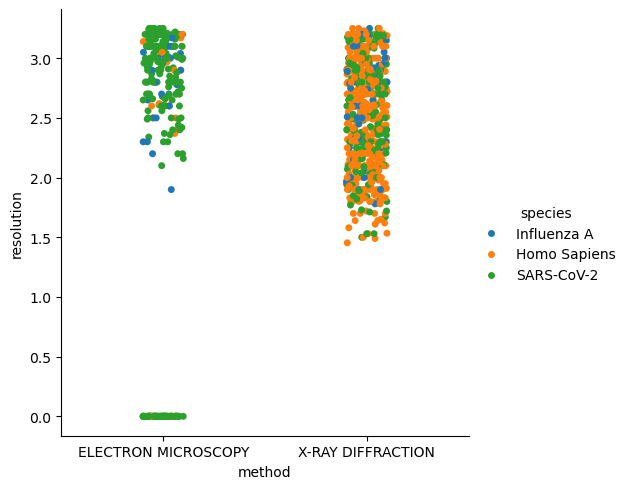

In [79]:
import seaborn as sns
#sns.catplot(df, x="organism", y="resolution", kind = "strip", hue="method")
sns.catplot(df_filtered,x="method", y="resolution", kind = "strip", hue="species")

In [ ]:
pd.crosstab(df_filtered["species"], df_filtered["method"])

method,ELECTRON MICROSCOPY,X-RAY DIFFRACTION
species,,
Homo Sapiens,36,363
Influenza A,38,61
SARS-CoV-2,250,218


In [54]:
df_filtered.antigen_chain.unique()

array(['E', 'A', 'D', 'B', 'C', 'R', 'H', 'I', 'P', 'F', 'X', 'K', 'Z',
       'J', 'Q', 'T', 'G', 'M', 'V', 'S', 'c', 'Y', 'U', 'm', 'b', 'N',
       'O', 'W'], dtype=object)

## Pdb Liste mit eindeutigen pdbs für Sars CoV 2 (Corona)

In [56]:
# Alle eindeutigen PDB-IDs aus der gefilterten DataFrame holen
pdb_ids_sars_cov2 = df_filtered.query("species == 'SARS-CoV-2'").get(['pdb'])

#save to file
pdb_ids_sars_cov2.to_csv("pdb_ids_sars_cov2.csv", index=False, header=True)

pdb_ids_sars_cov2

,pdb
46,9cci
47,9ccj
52,9bj2
53,9bj3
108,8z6r
...,...
5470,7chp
5482,7n4i
5511,7l7d
5514,7n3d


## Pdb Liste mit eindeutigen pdbs für Homo Sapiens

In [57]:
# Alle eindeutigen PDB-IDs aus der gefilterten DataFrame holen
pdb_ids_homo_sapiens = df_filtered.query("species == 'Homo Sapiens'").get(['pdb'])

#save to file
pdb_ids_homo_sapiens.to_csv("pdb_ids_homo_sapiens.csv", index=False, header=True)

pdb_ids_homo_sapiens

,pdb
29,8rmx
31,8rmy
128,8znz
144,9avo
145,9awe
...,...
5515,4od2
5516,7rp3
5517,3q1s
5518,4zfg


## Pdb Liste mit eindeutigen pdbs für Influenza A

In [58]:
# Alle eindeutigen PDB-IDs aus der gefilterten DataFrame holen
pdb_ids_influenza = df_filtered.query("species == 'Influenza A'").get(['pdb'])

#save to file
pdb_ids_influenza.to_csv("pdb_ids_homo_sapiens.csv", index=False, header=True)

pdb_ids_influenza

,pdb
5,8veb
8,8ved
11,8vee
14,8vef
20,9dpc
...,...
5352,4kvn
5366,5vag
5391,4hfu
5396,6lxi
